Main idea:

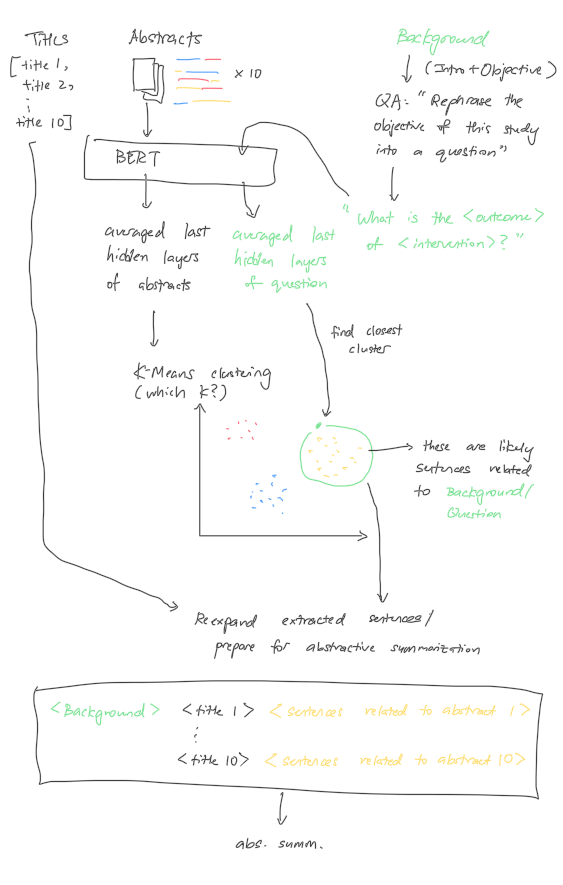

In [ ]:
!pip install -q datasets transformers[sentencepiece] accelerate
!pip install -q accelerate -U

***Extractive step: BERT, K means***

In [5]:
import typing
import warnings

from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.cluster import KMeans
from datasets import load_dataset
import pandas as pd
from pprint import pprint

warnings.filterwarnings("ignore", message=".*output with one or more elements was resized.*")
warnings.filterwarnings("ignore", message=".*the `device` argument is deprecated.*")

# Load the dataset and cut down to the first 5 for demonstration
full_dataset = load_dataset("allenai/mslr2022", "ms2", split='train')
dataset = full_dataset.select(range(3))  # Use select to create a subset

# Initialize BERT
bert_model_to_use = "dmis-lab/biobert-v1.1"
tokenizer = BertTokenizer.from_pretrained(bert_model_to_use)
model = BertModel.from_pretrained(bert_model_to_use)

/Users/michaelenghoekhor/Downloads/pytorch-test/env/lib/python3.8/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [2]:
def clean_text(text):
    """Clean text:
    - replace line breaks (\n) with spaces
    - replace " r and om" with "random" -- this word lemma occurs a lot in medical text!
    - same with "st and ard" -> "standard"
    - replace " ed " with "ed " -- past tense verbs are often separated from the word stem in this dataset
    - remove text "( ABSTRACT TRUNCATED" and everything after it, if it exists
    """
    text = text.replace('\n', ' ')
    text = text.replace(' r and om', ' random')
    text = text.replace(' st and ard', ' standard')
    text = text.replace(' ed ', 'ed ')
    if '( ABSTRACT TRUNCATED' in text:
        text = text[:text.index('( ABSTRACT TRUNCATED')]
    return text

def split_sentences(text):
    """From one abstract, split into sentences and return a list of sentences."""
    return text.split(' . ')


def bert_sentence_embeddings(sentences: typing.List[str]):
    inputs = tokenizer(sentences, return_tensors='pt', max_length=512, truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**inputs)
    # embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    # return np.array(embeddings)
    return embeddings.last_hidden_state.mean(dim=1).numpy()


def cluster_kmeans(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    return kmeans, cluster_labels
    top_sentence_indices = np.argmin(
        np.linalg.norm(embeddings[:, np.newaxis] - kmeans.cluster_centers_, axis=2),
        axis=0,
    )
    top_sentences = [sentences[index] for index in sorted(top_sentence_indices)]
    return ' '.join(top_sentences)

# def process_row(row):
#     review_id = row['review_id']
#     abstract_list = row['abstract']

#     combined_summary = ''

#     for abstract in abstract_list:
#         # Check if the abstract is a string; if not, join it into a single string
#         abstract_text = ' '.join(abstract) if isinstance(abstract, list) else abstract

#         # Split abstract into sentences
#         sentences = abstract_text.split('. ')
#         # Generate embeddings for each sentence
#         embeddings = bert_sentence_embeddings(sentences)
#         # Select the top sentences from these embeddings
#         summary = select_top_sentences(sentences, embeddings)

# #         # Print the top sentences for debugging
#         print("Top sentences for this abstract:", summary)


#         # Combine the summaries from each abstract
#         combined_summary += summary + ' '

#     return {"review_id": review_id, "summary": combined_summary.strip()}


In [5]:
# test
example_idx = 0
abstract_idx = 1
test_row = dataset[example_idx]
abstract = test_row['abstract'][abstract_idx]
clean_abstract = clean_text(abstract)
print("original:", abstract)
print("clean   :", clean_abstract)

test_split_sentences = split_sentences(clean_abstract)
print("split   :", test_split_sentences)


# split for all abstracts, concatenate into a single list while keeping track of which abstract idx it came from
all_split_sentences = []
abstract_idx_to_sentence_idx = []
for abstract_idx, abstract in enumerate(test_row['abstract']):
    clean_abstract = clean_text(abstract)
    one_abstract_split_sentences = split_sentences(clean_abstract)
    all_split_sentences.extend(one_abstract_split_sentences)
    abstract_idx_to_sentence_idx.extend([abstract_idx] * len(one_abstract_split_sentences))

# print with abstract idx per new line; only for first 3 abstracts
for abstract_idx, sentence in zip(abstract_idx_to_sentence_idx, all_split_sentences):
    if abstract_idx > 2:
        break
    print(f"{abstract_idx:2d}:", sentence)

test_embeddings = bert_sentence_embeddings(all_split_sentences)
print("avg'ed embeddings shape:", test_embeddings.shape)

# Also get the embedding for the background
test_background_embedding = bert_sentence_embeddings([clean_text(test_row["background"])])[0]
print(f"{test_background_embedding.shape=}")

# Apply the function to each element of the dataset
# summaries_dataset = dataset.map(process_row)

# Convert to pandas DataFrame
# df = pd.DataFrame(summaries_dataset)
# df = df[['review_id', 'summary']]
# Save to CSV
# csv_file_path = 'test.csv'  # Update with your desired file path
# df.to_csv(csv_file_path, index=True)

# print(f"Saved summaries to {csv_file_path}")

original: Abstract We investigated the effect of adipose-derived stem cells ( ADSCs ) transplantation effects on structural remodeling and pulmonary artery pressure in  monocrotaline (MCT)-induced pulmonary hypertensive rats . In the first experiment , 32 male Sprague-Dawley ( SD ) rats were r and omly divided into four groups ( n = 8/group ) : 3 ADSCs treated groups and normal control ( Ctrl ) . ADSCs were administered through the left jugular vein at 105 , 106 and 107 cells , respectively , and a cell density of 106cells/ml was shown to be optimal . The GFP-tagged ADSCs were identified in the lungs and differentiated into endothelial-like cells . In the second experiment , 96 male SD rats were r and omly divided into three groups ( n = 32/group ) : Ctrl , MCT-induced pulmonary arterial hypertension ( PAH ) , and PAH treated with ADSCs ( ADSCs ) . Two weeks post-MCT administration , the ADSCs group received 1 × 106 ADSCs via the external jugular vein . Compared to PAH rats , mean pulm

In [7]:
pprint(test_row["pmid"])

['22776744',
 '25271670',
 '3493740',
 '1863023',
 '16291984',
 '23984728',
 '23996433',
 '18466198',
 '12151469',
 '27400308',
 '16053970',
 '22922316',
 '11897647',
 '11597664',
 '4230647']


In [9]:
pprint(test_row["review_id"])

'30760312'


In [5]:
pprint(test_row["target"])

('Conclusions SC therapy is effective for PAH in pre clinical studies .\n'
 'These results may help to st and ardise pre clinical animal studies and '
 'provide a theoretical basis for clinical trial design in the future .')


In [4]:
pprint(test_row["background"])

('Background Despite significant progress in drug treatment , the prognosis of '
 'patients with advanced pulmonary arterial hypertension ( PAH ) remains '
 'extremely poor .\n'
 'Many pre clinical studies have reported the efficacy of stem cell ( SC ) '
 'therapy for PAH ; however , this approach remains controversial .\n'
 'The aim of this systematic review and meta- analysis is to assess the '
 'potential efficacy of SC therapy for PAH .')


In [6]:
objective_words = ["objective", "goal", "aim", "purpose"]
[b for b in full_dataset["background"] if not (any(o in b.lower() for o in objective_words))]

['BACKGROUND To achieve sufficient myocardial perfusion in ST-segment elevation myocardial infa rct ion ( STEMI ) patients receiving primary percutaneous coronary intervention ( PPCI ) , many adjunctive therapies have been proposed .\nPrevious trials have reported variances in myocardial perfusion improvement for statin pretreatment , which made it inconvincible to confirm the beneficial effects of statins .\nTherefore , we performed a systematic review and meta- analysis to determine whether statin pretreatment was effective in improving myocardial perfusion .\nHYPOTHESIS Statin pretreatment could improve myocardial perfusion in STEMI patients undergoing PPCI .',
 'Waterpipe tobacco smoking is growing in popularity despite adverse health effects among users .\nWe systematic ally review ed the literature , search ing MEDLINE , EMBASE and Web of Science , for interventions targeting prevention and cessation of waterpipe tobacco smoking .',
 'INTRODUCTION Surgical stress in the presence 

In [7]:
full_dataset["abstract"][0]

['Although transplantation of adult bone marrow mesenchymal stem cells ( BM-MSCs ) holds promise in the treatment for pulmonary arterial hypertension ( PAH ) , the poor survival and differentiation potential of adult BM-MSCs have limited their therapeutic efficiency . Here , we compared the therapeutic efficacy of human embryonic stem cell-derived MSCs ( hESC-MSCs ) with adult BM-MSCs for the treatment of PAH in an animal model . One week following monocrotaline (MCT)-induced PAH , mice were r and omly assigned to receive phosphate-buffered saline ( MCT group ) ; 3.0 × 106 human BM-derived MSCs ( BM-MSCs group ) or 3.0 × 106 hESC-derived MSCs ( hESC-MSCs group ) via tail vein injection . At 3 weeks posttransplantation , the right ventricular systolic pressure ( RVSP ) , degree of RV hypertrophy , and medial wall thickening of pulmonary arteries were lower= , and pulmonary capillary density was higher in the hESC-MSC group as compared with BM-MSC and MCT groups ( all p < 0.05 ) . At 1 w

In [10]:
# NOTE: some abstracts are truncated and have the text ABSRACT TRUNCATED at the end -- these should be removed

# [[b for b in a if "conclusion" not in b.lower()] for a in full_dataset["abstract"][:1]]
[[b for b in a if "abstract truncated" in b.lower()] for a in full_dataset["abstract"][:20]]
# [b for a in full_dataset["abstract"] for b in a if "abstract truncated" in b.lower()]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ["We have investigated the role of aluminized metal foil ( space blanket , UN 320 ) , used pre-emptively , in post-anaesthetic  shivering and patients ' subjective perception of cold after general anaesthesia of short duration . Sixty-eight ASA I and II patients undergoing orthopaedic and plastic surgery on the peripheries were allocated r and omly to two groups : those in group 1 were wrapped ( not less than 60 % of body surface area ) in the space blanket before induction of anaesthesia . In group 2 patients had st and ard surgical draping . In all subjects , anaesthesia was induced with fentanyl and propofol , and maintained with nitrous oxide and enflurane in oxygen , after a laryngeal mask airway was positioned . Patients were asked to grade their perception of cold on a visual analogue scale , before induction and on recovery . Skin ( dorsum of h and ) and core ( nasopharyngeal ) temperatures were recorded at 15-mi

In [158]:
# Experiment: use a QA model to rephrase background text as a question
from transformers import pipeline

# qa_model = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
qa_model = pipeline("question-answering", model="deepset/roberta-large-squad2")

# Question: what is the background?
# context = test_row["background"]
context = "The objective of this review is to evaluate the efficacy of oral cobalamin treatment in elderly patients ."
question = "What is a likely conclusion of this study?"
result = qa_model(question=question, context=context)
print(f"{result=}")

result={'score': 0.018638228997588158, 'start': 35, 'end': 104, 'answer': 'evaluate the efficacy of oral cobalamin treatment in elderly patients'}


In [11]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
context = test_row["background"]
# context = "The objective of this review is to evaluate the efficacy of oral cobalamin treatment in elderly patients ."
question = "In conclusion, we found that"
context_length = len(context.split())
generator(context + ". " + question, max_length=context_length + 50, num_return_sequences=5)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Background Despite significant progress in drug treatment , the prognosis of patients with advanced pulmonary arterial hypertension ( PAH ) remains extremely poor .\nMany pre clinical studies have reported the efficacy of stem cell ( SC ) therapy for PAH ; however , this approach remains controversial .\nThe aim of this systematic review and meta- analysis is to assess the potential efficacy of SC therapy for PAH .. In conclusion, we found that 1-hydroxytryptamine (1HT) therapy was superior to placebo for both the primary and treatment of PAH and it was particularly useful following the short-term'},
 {'generated_text': 'Background Despite significant progress in drug treatment , the prognosis of patients with advanced pulmonary arterial hypertension ( PAH ) remains extremely poor .\nMany pre clinical studies have reported the efficacy of stem cell ( SC ) therapy for PAH ; however , this approach remains controversial .\nThe aim of this systematic review and meta- 

In [13]:
test_kmeans, test_cluster_labels = cluster_kmeans(test_embeddings, 3)
print(test_kmeans.cluster_centers_)

for abstract_idx, sentence, cluster_label in zip(abstract_idx_to_sentence_idx, all_split_sentences, test_cluster_labels):
    if abstract_idx > 5:
        break
    print(f"abs {abstract_idx:2d}: clus {cluster_label:2d}:", sentence)


[[-0.03913197 -0.08717724  0.03830195 ...  0.04546279  0.10905725
  -0.14598805]
 [-0.13268995 -0.14975166 -0.05916374 ... -0.09789731  0.14748567
  -0.05868191]
 [-0.07005733 -0.05044009 -0.05239785 ...  0.04523812  0.01784303
  -0.04808953]]
abs  0: clus  1: Although transplantation of adult bone marrow mesenchymal stem cells ( BM-MSCs ) holds promise in the treatment for pulmonary arterial hypertension ( PAH ) , the poor survival and differentiation potential of adult BM-MSCs have limited their therapeutic efficiency
abs  0: clus  1: Here , we compared the therapeutic efficacy of human embryonic stem cell-derived MSCs ( hESC-MSCs ) with adult BM-MSCs for the treatment of PAH in an animal model
abs  0: clus  1: One week following monocrotaline (MCT)-induced PAH , mice were randomly assigned to receive phosphate-buffered saline ( MCT group ) ; 3.0 × 106 human BM-derived MSCs ( BM-MSCs group ) or 3.0 × 106 hESC-derived MSCs ( hESC-MSCs group ) via tail vein injection
abs  0: clus  0: A

Text(0, 0.5, 'Silhouette score')

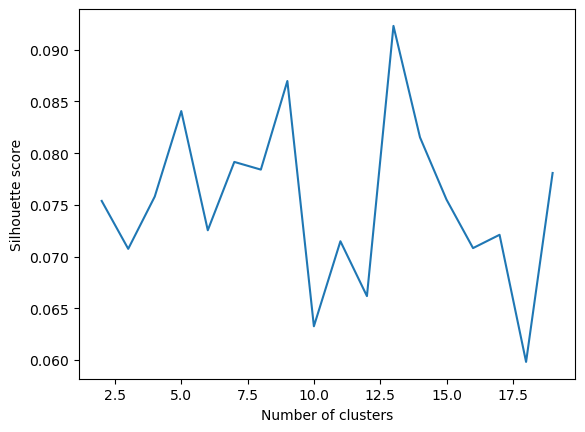

In [14]:
# construct an elbow test to find the optimal number of clusters
from sklearn.metrics import silhouette_score

def get_silhouette_score(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    return silhouette_avg

get_silhouette_score(test_embeddings, 10)

# how to interpret the silhouette score? https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# plot the silhouette score for different numbers of clusters
import matplotlib.pyplot as plt
import matplotlib.cm as cm

silhouette_scores = []
n_clusters_range = range(2, 20)
for n_clusters in n_clusters_range:
    silhouette_scores.append(get_silhouette_score(test_embeddings, n_clusters))

plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

In [17]:
# Alternative approach: calculate distance from background embedding
# test_background_embedding = bert_sentence_embeddings([clean_text(test_row["background"])])[0]
hack_text = "In conclusion, we found that 1-hydroxytryptamine (1HT) therapy was superior to placebo for both the primary and treatment of PAH and it was particularly useful following the short-term"
# hack_text = "In conclusion, the treatment had a positive effect"
# hack_text = "In conclusion, the treatment had no significant effect"
test_background_embedding = bert_sentence_embeddings([clean_text(hack_text)])[0]  # hack

test_distances = np.linalg.norm(test_embeddings - test_background_embedding, axis=1)
print(test_distances.shape)

# print per abstract: sorted by distance. also print abstract idx and distance
# for abstract_idx, sentence, distance in zip(abstract_idx_to_sentence_idx, all_split_sentences, test_distances):
#     if abstract_idx > 5:
#         break
#     print(f"abs {abstract_idx:2d}: dist {distance:2.2f}:", sentence)

for abstract_idx in range(5):
    # only get sentences from this abstract along with their distances
    abstract_distances = test_distances[np.array(abstract_idx_to_sentence_idx) == abstract_idx]
    abstract_sentences = np.array(all_split_sentences)[np.array(abstract_idx_to_sentence_idx) == abstract_idx]

    # get top sentences' indices
    top_sentence_indices = np.argsort(abstract_distances)[:3]

    # print all sentences in order with their distances. If it's a top sentence, mark it with a *
    for sentence_idx, (sentence, distance) in enumerate(zip(abstract_sentences, abstract_distances)):
        if sentence_idx in top_sentence_indices:
            print(f"abs {abstract_idx:2d}: dist {distance:2.2f}: *", sentence)
        else:
            print(f"abs {abstract_idx:2d}: dist {distance:2.2f}:  ", sentence)

    print("---")


(161,)
abs  0: dist 4.50: * Although transplantation of adult bone marrow mesenchymal stem cells ( BM-MSCs ) holds promise in the treatment for pulmonary arterial hypertension ( PAH ) , the poor survival and differentiation potential of adult BM-MSCs have limited their therapeutic efficiency
abs  0: dist 4.69: * Here , we compared the therapeutic efficacy of human embryonic stem cell-derived MSCs ( hESC-MSCs ) with adult BM-MSCs for the treatment of PAH in an animal model
abs  0: dist 4.89:   One week following monocrotaline (MCT)-induced PAH , mice were randomly assigned to receive phosphate-buffered saline ( MCT group ) ; 3.0 × 106 human BM-derived MSCs ( BM-MSCs group ) or 3.0 × 106 hESC-derived MSCs ( hESC-MSCs group ) via tail vein injection
abs  0: dist 4.40: * At 3 weeks posttransplantation , the right ventricular systolic pressure ( RVSP ) , degree of RV hypertrophy , and medial wall thickening of pulmonary arteries were lower= , and pulmonary capillary density was higher in th

In [3]:
# Simplest "model" -- follow the procedure for each abstract after sentence splitting:
# 1. Does the abstract contain the word "conclusion"? If so, get the sentence with the word "conclusion" in it and everything after it.
# 2. Otherwise, get the last two sentences.

def extract_simple(sentences: typing.List[str]) -> typing.List[typing.Tuple[int, str]]:
    """two step process. Return sentences to keep and their indices."""

    concluding_words = ["conclusion", "conclud"]
    for sentence in sentences:
        if any(c in sentence.lower() for c in concluding_words):
            return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= sentences.index(sentence)]

    return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= len(sentences) - 2]

In [6]:
# test
test_extracted_sentences = []
for abstract_idx, abstract in enumerate(test_row['abstract']):
    test_extracted_sentences.append(extract_simple(split_sentences(clean_text(abstract))))

# prepare for abstractive summarization: concatenate all sentences into a single string

for abstract_idx, extracted_sentences in enumerate(test_extracted_sentences):
    print(f"abs {abstract_idx:2d}:", extracted_sentences)

abs  0: [(8, 'We concluded that improved cell survival and paracrine capacity of hESC-MSCs provide better therapeutic efficacy than BM-MSCs in the treatment for PAH')]
abs  1: [(7, 'Meanwhile , the right heart hypertrophy index ( 36.2 1 ± 4.27 % versus 41.01 ± 1.29 % ; 39.47 ± 4.02 % versus 48.75 ± 2 .13 % ; 41.02 ± 0.9 % versus 50.52 ± 1.49 % , p < 0.05 , respectively ) , ratio of wall/lumen thickness , as well as the wall/lumen area were significantly reduced in PAH rats at these time points following ADSCs-treatment , as compared with untreated PAH rats'), (8, 'In summary , ADSCs may colonize the pulmonary arteries , attenuate pulmonary arterial hypertension and ameliorate pulmonary arterial remodeling')]
abs  2: [(3, 'Two weeks post-operation , our results demonstrated that sublingual vein injection of BMSCs significantly attenuated the pulmonary vascular structural and hemodynamic changes caused by pulmonary arterial hypertension'), (4, 'The mechanism may be executed via paracrine

***abstractive step***

In [12]:
import gc
import os
from transformers import AutoTokenizer, LongT5ForConditionalGeneration
from datasets import load_dataset
import pandas as pd
import torch
from torch.cuda.amp import autocast

# Memory optimization for CUDA
max_split_size_mb = 256  # Set the max_split_size_mb value (e.g., 512 MB)
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = f"max_split_size_mb:{max_split_size_mb}"
print(f"PYTORCH_CUDA_ALLOC_CONF is set to: {os.environ['PYTORCH_CUDA_ALLOC_CONF']}")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("mps")
print("device:", device)

# Load LongT5 Model and Tokenizer
# model_to_use = "google/long-t5-local-base"
# model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fined-tuned for summarization
model_to_use = "QizhiPei/biot5-base"
longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

ref_model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"
longt5_reference_model = LongT5ForConditionalGeneration.from_pretrained(ref_model_to_use).to(device)

max_token_length = 16384  # truly the limit of LongT5, but can reduce by multiples of 2 to optimize for speed if needed
max_summary_length = 512  # max length of the summary

PYTORCH_CUDA_ALLOC_CONF is set to: max_split_size_mb:256
device: mps


You are using a model of type t5 to instantiate a model of type longt5. This is not supported for all configurations of models and can yield errors.
Some weights of LongT5ForConditionalGeneration were not initialized from the model checkpoint at QizhiPei/biot5-base and are newly initialized: ['encoder.block.5.layer.0.LocalSelfAttention.v.weight', 'encoder.block.5.layer.0.LocalSelfAttention.q.weight', 'encoder.block.6.layer.0.LocalSelfAttention.v.weight', 'encoder.block.10.layer.0.LocalSelfAttention.q.weight', 'encoder.block.10.layer.0.LocalSelfAttention.o.weight', 'encoder.block.3.layer.0.LocalSelfAttention.k.weight', 'encoder.block.2.layer.0.LocalSelfAttention.o.weight', 'encoder.block.9.layer.0.LocalSelfAttention.o.weight', 'encoder.block.4.layer.0.LocalSelfAttention.k.weight', 'encoder.block.2.layer.0.LocalSelfAttention.q.weight', 'encoder.block.1.layer.0.LocalSelfAttention.k.weight', 'encoder.block.5.layer.0.LocalSelfAttention.o.weight', 'encoder.block.6.layer.0.LocalSelfAttention.

In [13]:
# what special tokens are there in QizhiPei/biot5-base? and how does it differ from pszemraj/long-t5-tglobal-base-16384-book-summary?

special_tokens = longt5_tokenizer.special_tokens_map
print("special tokens    :", special_tokens)

# get pszemraj tokens
pszemraj_tokenizer = AutoTokenizer.from_pretrained(ref_model_to_use)
pszemraj_special_tokens = pszemraj_tokenizer.special_tokens_map
print("ref special tokens:", pszemraj_special_tokens)

special tokens    : {'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>', '<extra_id_46>', '<extra_id_47>', '<extra_id_48>', '<extra_id_49>', '<extra_id_50>', '<extra_id_51>', '<extra_id

In [9]:
# Assuming the longt5_tokenizer and longt5_model are already correctly initialized

batch_size = 1  # this is my limit in Google Colab T4 before I start getting OOM issues

# Try summarizing a single review only -- from test_extracted_sentences
batch_abstracts = [". ".join([". ".join([s[1] for s in a]) for a in test_extracted_sentences])]
val_inputs = longt5_tokenizer.batch_encode_plus(
    batch_abstracts,
    return_tensors="pt",
    max_length=max_token_length,
    truncation=True,
    padding=True,
    return_attention_mask=True,
).to(device)
print(f"{val_inputs['input_ids']=}")

# Generate summaries
summary_ids = longt5_model.generate(
    val_inputs["input_ids"],
    attention_mask=val_inputs["attention_mask"],
    max_new_tokens=max_summary_length,
)

# Decode summaries
batch_summaries = longt5_tokenizer.batch_decode(
    summary_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True
)

print(batch_summaries)

val_inputs['input_ids']=tensor([[  101, 12179,    24,  ...,  2586,  2116,     1]], device='mps:0')
['In this study, we report on the efficacy of hescpscs in treating patients with plethylin-induced pulmonary hypertensity. We also show that adsorption of bmsc into the lungs attenuates the thromolysis and improves right heart hypertension. This is an important finding because it suggests that BMsc may be more effective than hESCs for treating pah.']


In [21]:
val_inputs["input_ids"].shape

torch.Size([1, 1012])

In [22]:
print("background:")
pprint(test_row["background"])
print("")
print("target:")
pprint(test_row["target"])
print("")
print("generated summary:")
pprint(batch_summaries[0])

background:
('Background Despite significant progress in drug treatment , the prognosis of '
 'patients with advanced pulmonary arterial hypertension ( PAH ) remains '
 'extremely poor .\n'
 'Many pre clinical studies have reported the efficacy of stem cell ( SC ) '
 'therapy for PAH ; however , this approach remains controversial .\n'
 'The aim of this systematic review and meta- analysis is to assess the '
 'potential efficacy of SC therapy for PAH .')

target:
('Conclusions SC therapy is effective for PAH in pre clinical studies .\n'
 'These results may help to st and ardise pre clinical animal studies and '
 'provide a theoretical basis for clinical trial design in the future .')

generated summary:
('In this study, we report on the efficacy of hescpscs in treating patients '
 'with plethylin-induced pulmonary hypertensity. We also show that adsorption '
 'of bmsc into the lungs attenuates the thromolysis and improves right heart '
 'hypertension. This is an important finding becau

In [14]:
# Training for newly initialized parameters (going from T5 to LongT5)
from transformers import Trainer, TrainingArguments
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = "0.0"
print(os.getenv('PYTORCH_MPS_HIGH_WATERMARK_RATIO'))


# Set up training using X samples from the dataset.
train_and_val_dataset = full_dataset.select(range(100))

# for each review_id in train/val, apply extract_simple to get the sentences to keep
# then concatenate them into a single string
def extract_simple_map(row):
    extracted_sentences = []
    for abstract in row['abstract']:
        extracted_sentences.append(extract_simple(split_sentences(clean_text(abstract))))
    return {
        "extracted_sentences": ". ".join([". ".join([s[1] for s in a]) for a in extracted_sentences])
    }

# apply extract_simple_map to each row
train_and_val_dataset = train_and_val_dataset.map(extract_simple_map)

# tokenize - get input_ids and attention_mask
train_and_val_dataset = train_and_val_dataset.map(
    lambda example: longt5_tokenizer(
        example["extracted_sentences"],
        padding="max_length",
        truncation=True,
        max_length=max_token_length,
    ),
    batched=True,
)

# tokenize the target (this will be called `labels` in the training step)
train_and_val_dataset = train_and_val_dataset.map(
    lambda example: {
        "labels": longt5_tokenizer.batch_encode_plus(
            example["target"],
            return_tensors="pt",
            max_length=max_summary_length,
            truncation=True,  # Truncate the target if it's too long
            padding=True,
        )["input_ids"],
    },
    batched=True,
)

# Set aside 20% for validation. The rest will be used for training. Randomize.
np.random.seed(42)
val_index = np.random.choice(len(train_and_val_dataset), size=int(len(train_and_val_dataset) * 0.2), replace=False)
val_dataset = train_and_val_dataset.select(val_index)
train_dataset = train_and_val_dataset.select([i for i in range(len(train_and_val_dataset)) if i not in val_index])

# train!

# only unfreeze relevant parameters:
newly_init_param_names = [
    'encoder.block.0.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.0.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.0.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.0.layer.0.LocalSelfAttention.relative_attention_bias.weight',
    'encoder.block.0.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.1.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.1.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.1.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.1.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.2.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.2.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.2.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.2.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.3.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.3.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.3.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.3.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.4.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.4.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.4.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.4.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.5.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.5.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.5.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.5.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.6.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.6.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.6.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.6.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.7.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.7.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.7.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.7.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.8.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.8.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.8.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.8.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.9.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.9.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.9.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.9.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.10.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.10.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.10.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.10.layer.0.LocalSelfAttention.v.weight',
    'encoder.block.11.layer.0.LocalSelfAttention.k.weight',
    'encoder.block.11.layer.0.LocalSelfAttention.o.weight',
    'encoder.block.11.layer.0.LocalSelfAttention.q.weight',
    'encoder.block.11.layer.0.LocalSelfAttention.v.weight',
]
# These are LongT5 parameters that are not in T5 (QizhiPei/biot5-base)

# If these params exist in longt5_reference_model, check to see if they're the same dimension in both models
# If they are, then we can copy the values over
for name, param in longt5_model.named_parameters():
    if name in newly_init_param_names:
        print(f"{name=}")
        if name in longt5_reference_model.state_dict().keys():
            print(f"{longt5_reference_model.state_dict()[name].shape=}")
            print(f"{param.shape=}")
            assert longt5_reference_model.state_dict()[name].shape == param.shape
            param.data = longt5_reference_model.state_dict()[name].data
        else:
            print(f"{name} not in longt5_reference_model")

params_unfrozen = set()
for name, param in longt5_model.named_parameters():
    if name in newly_init_param_names:
        param.requires_grad = True
        params_unfrozen.add(name)
    else:
        param.requires_grad = False

assert len(params_unfrozen) == len(newly_init_param_names)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=10,
    save_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=longt5_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=longt5_tokenizer,
)

# trainer.train()

0.0
name='encoder.block.0.layer.0.LocalSelfAttention.q.weight'
encoder.block.0.layer.0.LocalSelfAttention.q.weight not in longt5_reference_model
name='encoder.block.0.layer.0.LocalSelfAttention.k.weight'
encoder.block.0.layer.0.LocalSelfAttention.k.weight not in longt5_reference_model
name='encoder.block.0.layer.0.LocalSelfAttention.v.weight'
encoder.block.0.layer.0.LocalSelfAttention.v.weight not in longt5_reference_model
name='encoder.block.0.layer.0.LocalSelfAttention.o.weight'
encoder.block.0.layer.0.LocalSelfAttention.o.weight not in longt5_reference_model
name='encoder.block.0.layer.0.LocalSelfAttention.relative_attention_bias.weight'
encoder.block.0.layer.0.LocalSelfAttention.relative_attention_bias.weight not in longt5_reference_model
name='encoder.block.1.layer.0.LocalSelfAttention.q.weight'
encoder.block.1.layer.0.LocalSelfAttention.q.weight not in longt5_reference_model
name='encoder.block.1.layer.0.LocalSelfAttention.k.weight'
encoder.block.1.layer.0.LocalSelfAttention.k.we

In [19]:
longt5_model

LongT5ForConditionalGeneration(
  (shared): Embedding(35073, 768)
  (encoder): LongT5Stack(
    (embed_tokens): Embedding(35073, 768)
    (block): ModuleList(
      (0): LongT5Block(
        (layer): ModuleList(
          (0): LongT5LayerLocalSelfAttention(
            (LocalSelfAttention): LongT5LocalAttention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): LongT5LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): LongT5LayerFF(
            (DenseReluDense): LongT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out

In [20]:
longt5_reference_model

LongT5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): LongT5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): LongT5Block(
        (layer): ModuleList(
          (0): LongT5LayerTransientGlobalSelfAttention(
            (TransientGlobalSelfAttention): LongT5TransientGlobalAttention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
              (global_relative_attention_bias): Embedding(32, 12)
              (global_input_layer_norm): LongT5LayerNorm()
            )
            (layer_norm): LongT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): LongT5LayerFF(
            (DenseReluDense

In [17]:
list(longt5_reference_model.state_dict().keys())

['shared.weight',
 'encoder.embed_tokens.weight',
 'encoder.block.0.layer.0.TransientGlobalSelfAttention.q.weight',
 'encoder.block.0.layer.0.TransientGlobalSelfAttention.k.weight',
 'encoder.block.0.layer.0.TransientGlobalSelfAttention.v.weight',
 'encoder.block.0.layer.0.TransientGlobalSelfAttention.o.weight',
 'encoder.block.0.layer.0.TransientGlobalSelfAttention.relative_attention_bias.weight',
 'encoder.block.0.layer.0.TransientGlobalSelfAttention.global_relative_attention_bias.weight',
 'encoder.block.0.layer.0.TransientGlobalSelfAttention.global_input_layer_norm.weight',
 'encoder.block.0.layer.0.layer_norm.weight',
 'encoder.block.0.layer.1.DenseReluDense.wi_0.weight',
 'encoder.block.0.layer.1.DenseReluDense.wi_1.weight',
 'encoder.block.0.layer.1.DenseReluDense.wo.weight',
 'encoder.block.0.layer.1.layer_norm.weight',
 'encoder.block.1.layer.0.TransientGlobalSelfAttention.q.weight',
 'encoder.block.1.layer.0.TransientGlobalSelfAttention.k.weight',
 'encoder.block.1.layer.0.Tr

In [15]:
longt5_model.forward.__code__.co_varnames

('self',
 'input_ids',
 'attention_mask',
 'decoder_input_ids',
 'decoder_attention_mask',
 'head_mask',
 'decoder_head_mask',
 'cross_attn_head_mask',
 'encoder_outputs',
 'past_key_values',
 'inputs_embeds',
 'decoder_inputs_embeds',
 'labels',
 'use_cache',
 'output_attentions',
 'output_hidden_states',
 'return_dict',
 'hidden_states',
 'decoder_outputs',
 'sequence_output',
 'lm_logits',
 'loss',
 'loss_fct',
 'output')

In [49]:
# assert that there's no overlap between train and val
train_ids = [row["review_id"] for row in train_dataset]
val_ids = [row["review_id"] for row in val_dataset]
assert len(set(train_ids).intersection(set(val_ids))) == 0

## For entire validation set for evaluation

In [115]:
# Do the same but now for all of validation split

import os
import typing

from datasets import load_dataset
import numpy as np
import pandas as pd
from pprint import pprint
import torch
from transformers import AutoTokenizer, LongT5ForConditionalGeneration


# Load the dataset
full_val_dataset = load_dataset("allenai/mslr2022", "ms2", split='validation')
val_dataset = full_val_dataset.select(range(3))  # Use select to create a subset
# val_dataset = full_val_dataset  # Use this to run on the full dataset

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

# set up save dir
save_dir = "results_longt5_conclusion_only"
os.makedirs(save_dir, exist_ok=True)

# EXTRACTIVE "SUMMARIZATION"

def extract_simple(sentences: typing.List[str]) -> typing.List[typing.Tuple[int, str]]:
    """two step process. Return sentences to keep and their indices."""

    concluding_words = ["conclusion", "conclud"]
    for sentence in sentences:
        if any(c in sentence.lower() for c in concluding_words):
            return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= sentences.index(sentence)]

    return [(s_idx, s) for s_idx, s in enumerate(sentences) if s_idx >= len(sentences) - 2]

# split for all abstracts, concatenate into a single list while keeping track of which abstract idx it came from
val_extracted_sentences: typing.Dict[str, typing.List[typing.Tuple[int, str]]] = {}
# dict (key: review_id) of lists (abstracts) of tuples (sentence_idx, sentence)
for review_id, abstracts_list in zip(val_dataset["review_id"], val_dataset["abstract"]):
    review_id = typing.cast(str, review_id)
    abstracts_list = typing.cast(typing.List[str], abstracts_list)
    val_extracted_sentences[review_id] = []
    for abstract_idx, abstract in enumerate(abstracts_list):
        clean_abstract = clean_text(abstract)
        one_abstract_split_sentences = split_sentences(clean_abstract)
        val_extracted_sentences[review_id].append(extract_simple(one_abstract_split_sentences))

# ABSTRACTIVE SUMMARIZATION

# Load LongT5 Model and Tokenizer

# Memory optimization for CUDA
if torch.cuda.is_available():
    max_split_size_mb = 256  # Set the max_split_size_mb value (e.g., 512 MB)
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = f"max_split_size_mb:{max_split_size_mb}"
    print(f"PYTORCH_CUDA_ALLOC_CONF is set to: {os.environ['PYTORCH_CUDA_ALLOC_CONF']}")
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Load LongT5 Model and Tokenizer
model_to_use = "pszemraj/long-t5-tglobal-base-16384-book-summary"  # fined-tuned for summarization
longt5_model = LongT5ForConditionalGeneration.from_pretrained(model_to_use).to(device)
longt5_tokenizer = AutoTokenizer.from_pretrained(model_to_use)

batch_size = 1
max_token_length = 16384  # truly the limit of LongT5, but can reduce by multiples of 2 to optimize for speed if needed
prefix = "summarize conclusion concisely: "

all_summaries_embedding = []
all_batched_summaries = []
for i in range(0, len(val_extracted_sentences), batch_size):
    # create slice
    batch_review_ids = list(val_extracted_sentences.keys())[i:i+batch_size]
    batch_extracted_sentences = [val_extracted_sentences[review_id] for review_id in batch_review_ids]
    batch_concatenated_sentences = []
    for review_id, extracted_sentences in zip(batch_review_ids, batch_extracted_sentences):  # per review
        background_text = val_dataset["background"][val_dataset["review_id"].index(review_id)]
        batch_concatenated_sentences.append(
            prefix
            + ". ".join([". ".join([study_tuple[1] for study_tuple in study]) for study in extracted_sentences])
            + ". " + clean_text(background_text)
        )

    val_inputs = longt5_tokenizer.batch_encode_plus(
        batch_concatenated_sentences,
        return_tensors="pt",
        max_length=max_token_length,
        truncation=True,
        padding=True,
        return_attention_mask=True,
    ).to(device)

    # Generate summaries
    summary_ids = longt5_model.generate(
        val_inputs["input_ids"],
        attention_mask=val_inputs["attention_mask"],
        max_new_tokens=256,
        num_beams=2,  # default: 2
    )

    # Decode summaries
    batch_summaries = longt5_tokenizer.batch_decode(
        summary_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )
    all_batched_summaries.extend(batch_summaries)

    pprint(batch_summaries, width=150)

    # save to file
    for review_id, summary in zip(batch_review_ids, batch_summaries):
        with open(os.path.join(save_dir, f"{review_id}.txt"), "w") as f:
            f.write(summary)

    # clear memory
    del val_inputs
    del summary_ids
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()
    gc.collect()

device: mps
['In this paper, the authors present a novel approach to preventing necrotizing Enterocolitis in premature infants. They describe a new type of '
 'prebiotic formula that induces feal-like bifbiota at birth and conclude that it does not improve survival in preterm babies. However, there is a '
 'trend towards a lower risk of serious epidemics in these patients. The results suggest that enteral feeding with a small amount of preorganic '
 'ingredients can be effective in reducing the risk of nosocomisal infection in early childhood.']
['In this paper, we describe the effects of glucoganan on body weight and blood lipids in two ad rothed subjects. The results show that glucagann is '
 'an effective dietary adjunct to lower LDL-cholesterol levels in overweight subjects. Furthermore, it does not cause additional weight loss in '
 'healthy subjects. However, there are some side effects. These include increased blood triglycerides and elevated blood pressure. This study '
 'sugge

In [118]:
n = len(all_batched_summaries)
for bg, trgt, gen in zip(val_dataset["background"][:n], val_dataset["target"][:n], all_batched_summaries):
    print("background:")
    pprint(bg)
    print("")
    print("generated summary:")
    pprint(clean_text(gen))
    print("")
    print("target:")
    pprint(clean_text(trgt))
    print("---")
    print("")


background:
('Necrotizing enterocolitis ( NEC ) is one of the most serious '
 'gastrointestinal emergencies in very low birth weight ( VLBW ) preterm '
 'neonates , affecting 7 - 14 % of these neonates .\n'
 'Due to the seriousness of the disease , prevention of NEC is the most '
 'important goal .')

generated summary:
('In this paper, the authors present a novel approach to preventing '
 'necrotizing Enterocolitis in premature infants. They describe a new type of '
 'prebiotic formula that induces feal-like bifbiota at birth and conclude that '
 'it does not improve survival in preterm babies. However, there is a trend '
 'towards a lower risk of serious epidemics in these patients. The results '
 'suggest that enteral feeding with a small amount of preorganic ingredients '
 'can be effective in reducing the risk of nosocomisal infection in early '
 'childhood.')

target:
('Current evidence from systematic review and meta- analysis revealed that '
 'probiotics are the most promising 